In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import networkx as nx
import random
from itertools import product, permutations
import time

style.use('ggplot')
np.random.seed(8) 


In [2]:
prob_of_intraconnection = 0.5
prob_of_interconnection = 0.2
opinions_bag = [-1.0, -0.5, 0.0, 0.5, 1.0]
N = 4  # number of nodes

In [3]:
''' 
MDP environment definition:

state = tuple(all opinions)
actions = [(j, i)] "node j influences node i (and j remains the same)"
reward = - (total polarity) + (guidance reward)
guidance reward = -5 if all nodes in new state have the same sign
terminal reward = +20 if all nodes in new state have opinion 0,
                  -20 if all nodes have same opinion but not 0
'''

' \nMDP environment definition:\n\nstate = tuple(all opinions)\nactions = [(j, i)] "node j influences node i (and j remains the same)"\nreward = - (total polarity) + (guidance reward)\nguidance reward = -5 if all nodes in new state have the same sign\nterminal reward = +20 if all nodes in new state have opinion 0,\n                  -20 if all nodes have same opinion but not 0\n'

# ~ Definitions ~

In [4]:
def apply_recommendation(s_i, s_j):
    ''' 
    Returns a 'next states' list of tuples as: [(probability, new_opinion value)]
    following the given influence rules. Assumes a step = 0.5.
    The equivalent of the opinion_update() we defined above, but for the MDP setting 
    (i.e. needed to create transition probabilites matrix)
    '''
    step = 0.5
    diff = abs(s_i - s_j)
    
    if diff ==0.5:
        return [(0.6, s_j), (0.4, s_i)] # with probability 0.6, s_i_new = s_j, with p=0.4, s_i_new = s_i_old
        
    elif diff >= 1:
        next_states = []
        move = step*2

        sign = 1 if s_j> s_i else -1
        towards = s_i + sign * move
        away = s_i - sign * step

        towards = max(-1, min(1, towards))
        away = max(-1, min(1, away))
        new_states = [(0.4, towards), (0.3, s_i), (0.3, away)]
        return new_states
    else:
        return[(1.0, s_i)]

In [5]:
def is_terminal(state):
    ''' 
    Takes in a state (all nodes' opinions) and
    returns `done` , `reward` values.
    I define my terminal states those where all
    opinions are equal. If they are zero, i get
    a positive reward, otherwise I get negative 
    terminal reward.
    '''
    unique = set(state)
    if len(unique) == 1:  # if all nodes' opinions end up being the same:
        if abs(state[0]) == 0:
            return True, +20
        else:
            return True, -20
    return False, 0

In [6]:
def force_no_isolates(graph):
    '''
    Connects isolated nodes randomly to other nodes.
    '''
    print('Connecting isolated nodes randomly...')
    isolates = list(nx.isolates(graph))
    print(f'  List of isolated nodes:  {isolates}')
    for n in isolates:
        not_isolates = list(set(graph.nodes()) - {n})
        some_connected_guy = int(np.random.choice(not_isolates))
        graph.add_edge(n, some_connected_guy)

In [7]:
def get_valid_actions_list(graph):
    '''
    Returns a list of all edges of a graph in bidirectional manner.
    The list corresponds to the permitted actions for my RL agent.
    '''
    edges = list(graph.edges)
    actions = [ (g, h) for g, h in edges] + [(h, g) for g, h in edges]
    return actions

In [8]:
def get_total_polarization(graph):
    ''' 
    Returns the sum of absolute values of opinion attributes of all nodes
    We define this quantity as the total polarization.
    '''
    values = nx.get_node_attributes(graph, 'opinion').values()
    opinion_list = np.array(list(values))
    total_polarization = np.sum(np.abs(opinion_list))
    return total_polarization

In [9]:
def create_random_net(N, p=prob_of_intraconnection):  
    '''
    Creates a random graph network with N nodes,
    with probability of intraconnection p.
    Returns graph G, states s, actions a.
    --------------------------------------
    TODO: make sure there is connecting path from
    every node to every node. Now there are cases 
    where it returns isolated groups. And force_no_
    isolates is not enough backup.
    '''    
    print('Creating graph...')
    G = nx.Graph()
    G.add_nodes_from(range(N))

    opinions = np.random.choice(opinions_bag, size = N).tolist()
    
    nx.set_node_attributes(G, values = {i: opinions[i] for i in range(N)}, name = 'opinion')

    for i in range(N):
        for j in range(i+1, N):
            if np.random.rand() > p :
                G.add_edge(i,j)
    if len(list(nx.isolates(G))) > 0:
        force_no_isolates(G)
        
            
    actions = get_valid_actions_list(G)    
    states = list(product(opinions_bag, repeat=N))

    G.graph['n_s'] = len(states)
    G.graph['n_a'] = len(actions)

    
    print('Number of states for this graph:' ,len(states), '\n  Number of possible actions:', len(actions))    
    print('  Nodes\' initial opinions', opinions)
    print('  Total polarization:', get_total_polarization(G))
    
    
    return G, states, actions

In [10]:
def force_no_isolates_in_chambers(graph, group):
    '''
    Connects isolated nodes randomly within their group.
    '''
    print('Connecting isolated nodes randomly...')
    for n in group:
        friends = set(graph[n])  # I get the adjacent nodes
        if len(friends.intersection(group)) == 0:
            some_connected_friend = int(np.random.choice([node for node in group if node != n]))
            graph.add_edge(n, some_connected_friend)
        

    

In [11]:
def create_echo_chambers(N, p=prob_of_intraconnection, q=prob_of_interconnection):
    '''
    Creates a random graph network with N nodes, assigns
    opinions and separates in two equal 'echo-chambers' 
    with probability of intraconnection p 
    and probability of interconnection q. 
    If number of nodes is not even , it adds 1 node.
    '''
    
    print('Creating graph...')

    if N % 2 == 1:
        N += 1
        print('Added one extra node to get equal numbered chambers. Total nodes now: ', N)
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    group1 = list(range(N//2))
    group2 = list(range(N//2, N)) # N must be even
    
    opinions_group1 = np.random.choice([-1.0, -0.5], size= N//2)  # initial opinions
    opinions_group2 = np.random.choice([0.5, 1.0], size= N//2)    # do not contain neutral opinions
    
    opinions = np.concatenate([opinions_group1, opinions_group2])
    nx.set_node_attributes(G, values= {i: opinions[i] for i in range(N)}, name='opinion')
    
    # intraconnect:
    for group in [group1, group2]:       # in each group
        for i in range(len(group)):      # for each node 
            for j in range(i+1, len(group)): # see the other (remaining ) nodes
                if np.random.rand() < p:     # and with probability p
                    G.add_edge(group[i], group[j]) # connect them together.
        if len(list(nx.isolates(G))) > 0:          # if some isolates happened,
            force_no_isolates_in_chambers(G, group) # connect them randomly for now.
    
    
    # interconnect:
    for i in group1:
        for j in group2:
            if np.random.rand() < q:
                G.add_edge(i,j)
    
    # making sure I don't get isolated chambers:
    if not any(G.has_edge(i,j) for i in group1 for j in group2): 
        i = int(np.random.choice(group1))
        j = int(np.random.choice(group2))
        G.add_edge(i,j)

    actions = get_valid_actions_list(G)    
    states = list(product(opinions_bag, repeat=N))    
    G.graph['n_s'] = len(states)
    G.graph['n_a'] = len(actions)
    
    print('Number of states for this graph:' ,len(states), '\n  Number of possible actions:', len(actions))    
    print('  Nodes\' initial opinions', opinions)
    print('  Total polarization:', get_total_polarization(G))

    
    return G, states, actions

In [12]:
def draw_opinion_graph(graph, random = False, filename = None):
    '''
    Simple function to quickly draw the networkx opinion graph with the correct formatting.
    '''

    if not random:
        for i, j in graph.edges():
            s_i = graph.nodes[i]['opinion']
            s_j = graph.nodes[j]['opinion']
    
            if s_i == s_j:
                weight = 10
            elif s_i * s_j < 0:
                weight =0.5
            else:
                weight = 4
            graph[i][j]['weight'] = weight
        pos = nx.spring_layout(graph, weight='weight')
    else:
        pos = nx.spring_layout(graph)

        
    nx.draw(graph, pos, with_labels=True, 
                   node_color=[graph.nodes[i]['opinion'] for i in graph.nodes()],
                   cmap=plt.cm.coolwarm,         
                   width=0.3,                 
                  vmin = -1.0,
                  vmax = 1.0)
    plt.text(0.01, 0.09, f"Number of states: {graph.graph['n_s']}",
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom')
    plt.text(0.01, 0.05, f"Number of actions: {graph.graph['n_a']}",
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom')

    if filename:
        plt.savefig(filename)
    plt.show()

    return
 

In [13]:
def create_transition_prob(graph, states, actions):
    '''
    Takes a graph, its states and valid actions, 
    and creates the transition probability matrix.
    Returns the P, and the dictionaries of the state indexes.
    '''
    # opinions = [-1.0, -0.5, 0.5, 1.0] if not echo else [-1.0, -0.5, 0, 0.5, 1.0]
        
    
    N = graph.number_of_nodes()
    states = states

    # Essential dictionaries which willl guide the transitions:
    state_to_index = {s: i for i, s in enumerate(states)}
    index_to_state = {i: s for i, s in enumerate(states)}
    print(f'For the graph {graph} \n \ with Number of states {len(states)} \n \ and number of possible actions {len(actions)}')
    print(' Creating matrix P ...')
    
    
    ###############################################
    ### CREATING THE !!! TRANSITION TABLE !!!!! ###
    ###############################################
    P = [[[] for _ in actions] for _ in states]  # it is a list: [ state1, state2,...] where state1 = [action1, action2...]
                                                    #and where action1 = [transition_prob_info]
                                                    # and where transition_prob_info = [prob, nextstate, reward, done]
    for i, state in enumerate(states):
        
        for a_index, (i_node, j_node) in enumerate(actions):
            s_i, s_j = state[i_node], state[j_node]
            transitions = apply_recommendation(s_i, s_j) # here I actually get the next state of each s,a with the 
                                                            # coressponding transition probability ( P, s_i_new)
            # now for each transition probability of the influenced node:
            for prob, s_i_new in transitions:
                new_state = list(state)                  # I convert the tuple state to list
                new_state[i_node] = s_i_new              # I change the state of the (changed) node
                new_state = tuple(new_state)             # I convert the list to tuple
                next_state_index = state_to_index[new_state]        # to find where in the transition table is my new state
                
                done, terminal_reward = is_terminal(new_state)   # I check if my new state is terminal
                
                reward = -sum(abs(x) for x in new_state) + terminal_reward
                
                if terminal_reward == 0: # giving some intermediate "guidance" to discourage/avoid stalling
                    if all(x > 0 for x in new_state) or all(x < 0 for x in new_state):
                        reward -= 5
                
                P[i][a_index].append((prob, next_state_index, reward, done))
    ###############################################
    #############           !           ###########
    ###############################################
    
    print(' P matrix created.\n Format: P[state-index][action-index] = \n        [(probability of transition, next state index number, reward, done)].')

    return P, state_to_index, index_to_state
    

In [14]:
def random_policy(P):
    '''
    Takes a transition probability 'matrix' and returns
    a random policy pi, in which chooses a random index from the
    list of available indices of a state P[s].
    '''
    random_pi = lambda s: np.random.choice([a for a in range(len(P[s]))])
    return random_pi

In [15]:
def biased_policy(P,actions, index_to_state):
    '''
    Takes a transition probability 'matrix', list of valid
    actions and the indices which corresponf each state. 
    Returns a biased policy which chooses always the
    the j node with the smallest difference in opinions.
    ---------------------------------------------------
    NOTE: AI declaration: ChatGPT was uded to create this lambda
    function in this manner. I take minimal credit for this.
    ---------------------------------------------------
    '''
    pi = lambda s: min(
        range(len(actions)),
        key=lambda a_idx: abs(index_to_state[s][actions[a_idx][0]] - index_to_state[s][actions[a_idx][1]])
    )
    return pi


In [16]:
def value_iteration(P, actions, index_to_state, gamma=1.0, epsilon=1e-10, verbose=False):
    ''' 
    My value iteration function. Followed the FrozenLake example format
    as well as a few examples from https://github.com/JerryJohnThomas .
    '''
    vprint = print if verbose else lambda *a, **k: None
    
    V = np.zeros(len(P))
    t = 0

    while True:
        t +=1
        Q = np.zeros((len(P), len(P[0])))
        
        for s in range(len(P)):                # s is the state index and a is the action index in the P list (of lists of lists)
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * ( reward + gamma*V[next_state]*(not done) )   

        V_new = np.max(Q, axis=1)
        if np.max(np.abs(V - V_new)) < epsilon:
            break        
        V = V_new

    pi = lambda s: np.argmax(Q[s])           # choosing only the row of the state ...
    for i in range(len(P)):
        best_action_index = pi(i)            # ...and check for the index ... 
        best_action = actions[best_action_index]  # ...which corresponds to the max val of the action.
        vprint(f'State {index_to_state[i]} --> Best action {best_action}')

    print('Converged after %d iterations' %t)  # number of iterations to converge
    # print(f'optimal pi: {pi}')
    return V, pi

In [17]:
def simulate_policy_and_plot(P, pi, state_to_index, index_to_state, actions, initial_state, rounds=10, filename=None):
    '''
    Takes the transition probabilities P,
    the optimal policy pi from the Value Iteration,
    is guided with indexes in P,
    takes the list of possible actions,
    an initial state (given tuple) and assumes steps = 10.
    '''
    current_state = initial_state
    polarization_history = []

    print(f'Initial state: {current_state}')

    for r in range(rounds):
        polarization = sum(abs(x) for x in current_state)
        polarization_history.append(polarization)

        s = state_to_index[current_state]
        a = pi(s)
        action = actions[a]

        transitions = P[s][a]                  # transition procedure starts
        probs = [t[0] for t in transitions]
        outcomes = [t[1:] for t in transitions]
        chosen = random.choices(outcomes, weights=probs, k=1)[0]
        next_state_index, reward, done = chosen
        next_state = index_to_state[next_state_index]   
        print(f'Round {r + 1}: Action {action}, Next State {next_state}, Polarization {polarization:.2f}')
        current_state = next_state        # transition procedure ends

        if done:
            print('--- Episode Terminated ---')
            break

    polarization = sum(abs(x) for x in current_state) # getting the final polarization 
    polarization_history.append(polarization)         # and logging it for plotting

    # plotting 
    plt.figure()
    plt.plot(polarization_history, marker='o')
    plt.title('Total Polarization Over Time')
    plt.xlabel('Time step')
    plt.ylabel('Total Polarization')
    plt.xticks(range(len(polarization_history))) 
    plt.yticks(np.arange(0, max(polarization_history) + 1, 0.5))
    # plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()
    return


In [18]:
def create_validation_net(N, p=prob_of_intraconnection, opinions=[_]):  
    '''
    Creates a graph network with N nodes,
    and with set opinion attributes.
    Returns graph G, states s, actions a.
    '''    
    print('Creating graph...')
    G = nx.Graph()
    G.add_nodes_from(range(N))

    opinions = opinions
    
    nx.set_node_attributes(G, values = {i: opinions[i] for i in range(N)}, name = 'opinion')

    for i in range(N-1):
        # for j in range(i+1, N):
        G.add_edge(i,i+1)        
            
    actions = get_valid_actions_list(G)    
    states = list(product(opinions_bag, repeat=N))

    G.graph['n_s'] = len(states)
    G.graph['n_a'] = len(actions)
    values = nx.get_node_attributes(G, 'opinion').values()
    opinion_list = np.array(list(values))
    total_polarization = np.sum(np.abs(opinion_list))
    
    print('Number of states for this graph:' ,len(states), '\n  Number of possible actions:', len(actions))    
    print('  Nodes\' initial opinions', opinions)
    print('  Total polarization:', total_polarization)
    
    
    return G, states, actions

# TASK 1 : Implementing the two graph models

## Creating instances of graphs

In [19]:
G1, states1, actions1 = create_random_net(6)

Creating graph...
Number of states for this graph: 15625 
  Number of possible actions: 16
  Nodes' initial opinions [0.5, 1.0, -0.5, -0.5, 0.0, -1.0]
  Total polarization: 3.5


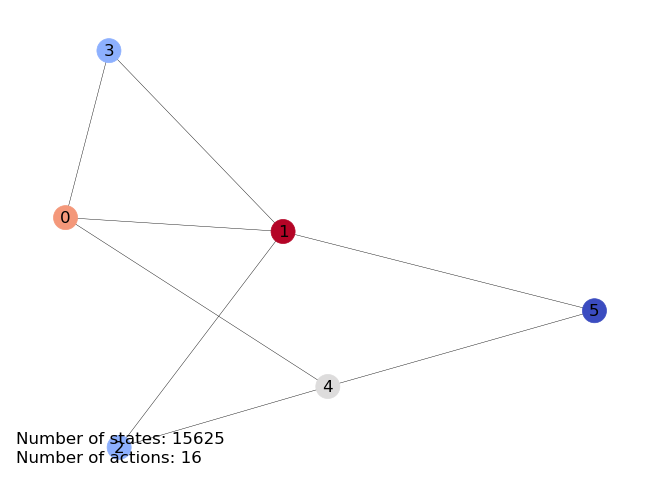

In [20]:
draw_opinion_graph(G1, random = True, filename='G1-6.png')

In [21]:
G2, states2, actions2 = create_echo_chambers(6)

Creating graph...
Connecting isolated nodes randomly...
Number of states for this graph: 15625 
  Number of possible actions: 12
  Nodes' initial opinions [-1.  -0.5 -0.5  0.5  0.5  1. ]
  Total polarization: 4.0


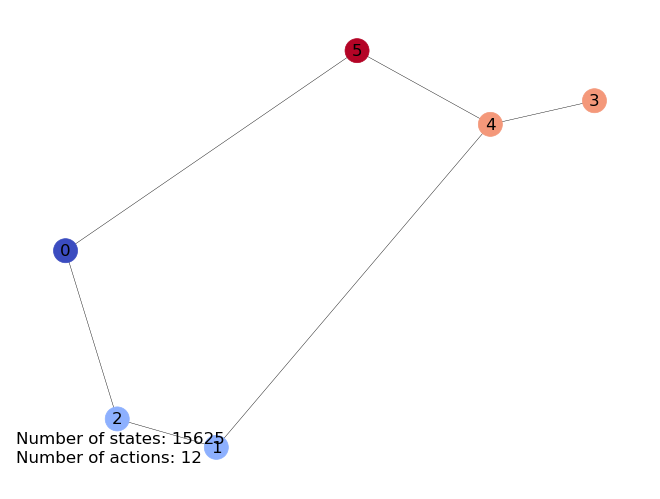

In [22]:
draw_opinion_graph(G2, random = False, filename='G2-6.png')

## Transition probabilities

In [23]:
GA, sA, aA = create_random_net(N)
while len(aA) == 4:   # temporal solution for random graphs of 4 nodes that have isolated elements
    print('Trying again for properly connected graph...\n')
    GA, sA, aA = create_random_net(N)

Creating graph...
Connecting isolated nodes randomly...
  List of isolated nodes:  [0, 1]
Number of states for this graph: 625 
  Number of possible actions: 4
  Nodes' initial opinions [1.0, 0.0, 0.5, 0.5]
  Total polarization: 2.0
Trying again for properly connected graph...

Creating graph...
Connecting isolated nodes randomly...
  List of isolated nodes:  [1, 3]
Number of states for this graph: 625 
  Number of possible actions: 6
  Nodes' initial opinions [1.0, 0.5, 1.0, 0.5]
  Total polarization: 3.0


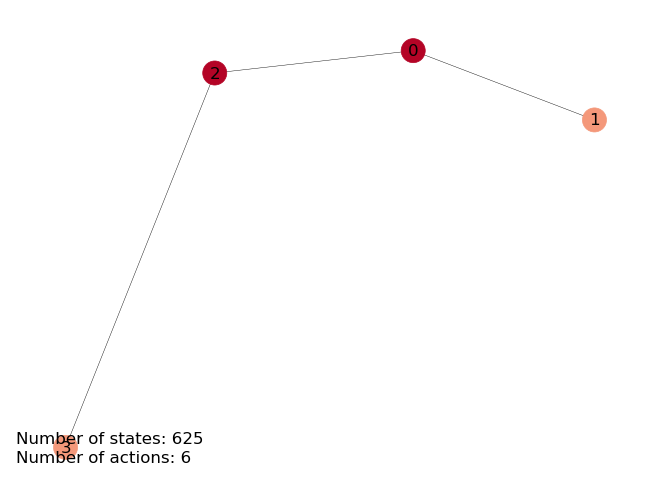

For the graph Graph with 4 nodes and 3 edges 
 \ with Number of states 625 
 \ and number of possible actions 6
 Creating matrix P ...
 P matrix created.
 Format: P[state-index][action-index] = 
        [(probability of transition, next state index number, reward, done)].


In [24]:
draw_opinion_graph(GA, random = True, filename='GA.png')
PA, stiA, itsA = create_transition_prob(GA, sA, aA)

In [25]:
GB, sB, aB = create_echo_chambers(N)

Creating graph...
Connecting isolated nodes randomly...
Number of states for this graph: 625 
  Number of possible actions: 6
  Nodes' initial opinions [-0.5 -1.   1.   0.5]
  Total polarization: 3.0


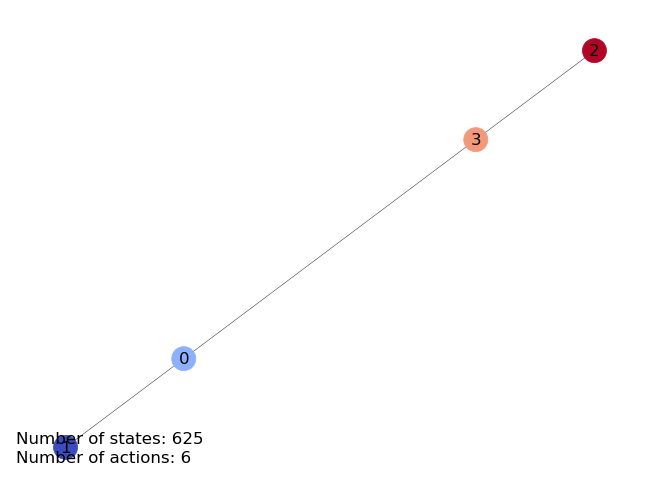

For the graph Graph with 4 nodes and 3 edges 
 \ with Number of states 625 
 \ and number of possible actions 6
 Creating matrix P ...
 P matrix created.
 Format: P[state-index][action-index] = 
        [(probability of transition, next state index number, reward, done)].


In [26]:
draw_opinion_graph(GB, random = False, filename='GB.png')
PB, stiB, itsB = create_transition_prob(GB, sB, aB)

# TASK 2 : Implementing a simple influence model

In [27]:
rand_pi_A = random_policy(PA)

Initial state: (-1, -0.5, 0.5, 1)
Round 1: Action (2, 0), Next State (-1.0, -0.5, 0.5, 1.0), Polarization 3.00
Round 2: Action (2, 0), Next State (-1.0, -0.5, 1.0, 1.0), Polarization 3.00
Round 3: Action (0, 2), Next State (-1.0, -0.5, 1.0, 1.0), Polarization 3.50
Round 4: Action (1, 0), Next State (-1.0, -0.5, 1.0, 1.0), Polarization 3.50
Round 5: Action (1, 0), Next State (-1.0, -1.0, 1.0, 1.0), Polarization 3.50
Round 6: Action (0, 2), Next State (-1.0, -1.0, 1.0, 1.0), Polarization 4.00
Round 7: Action (1, 0), Next State (-1.0, -1.0, 1.0, 1.0), Polarization 4.00
Round 8: Action (0, 1), Next State (-1.0, -1.0, 1.0, 1.0), Polarization 4.00
Round 9: Action (0, 2), Next State (0.0, -1.0, 1.0, 1.0), Polarization 4.00
Round 10: Action (3, 2), Next State (0.0, -1.0, 1.0, 1.0), Polarization 3.00


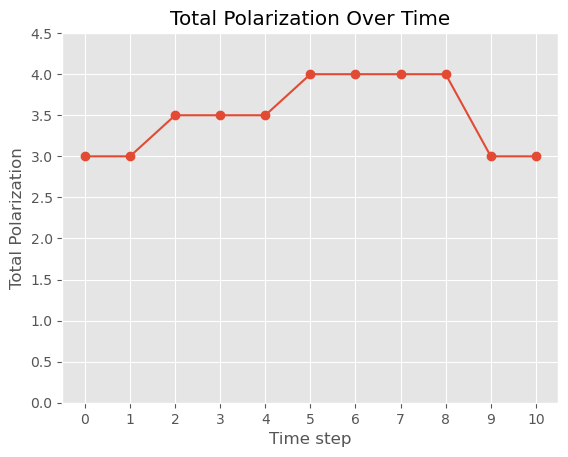

In [28]:
simulate_policy_and_plot(PA, rand_pi_A, stiA, itsA, aA, initial_state=(-1,-0.5,0.5,1), filename='GA-Nolearn.png', rounds=10)

Initial state: (-1, -0.5, 0.5, 1)
Round 1: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 3.00
Round 2: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 3: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 4: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 5: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 6: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 7: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 8: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 9: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 10: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50


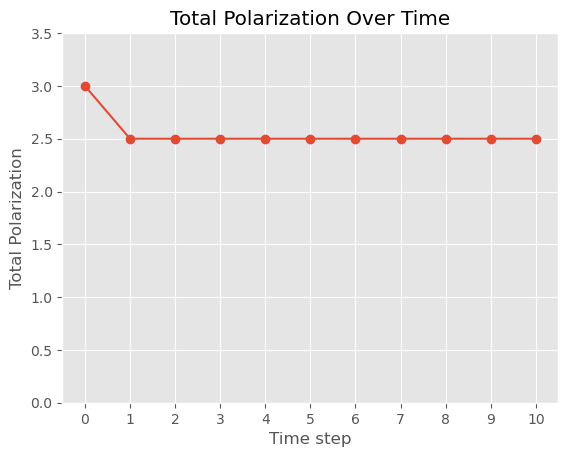

In [29]:
bias_pi_A = biased_policy(PA, aA, itsA)
simulate_policy_and_plot(PA, bias_pi_A, stiA, itsA, aA, initial_state=(-1,-0.5,0.5,1), filename='GA-bias.png')

Initial state: (-1, -0.5, 0.5, 1)
Round 1: Action (1, 0), Next State (-1.0, -0.5, 0.5, 1.0), Polarization 3.00
Round 2: Action (3, 0), Next State (-1.0, -0.5, 0.5, 1.0), Polarization 3.00
Round 3: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 3.00
Round 4: Action (2, 3), Next State (-0.5, -0.5, 1.0, 1.0), Polarization 2.50
Round 5: Action (1, 0), Next State (-0.5, -0.5, 1.0, 1.0), Polarization 3.00
Round 6: Action (2, 3), Next State (-0.5, -0.5, 1.0, 1.0), Polarization 3.00
Round 7: Action (3, 2), Next State (-0.5, -0.5, 1.0, 1.0), Polarization 3.00
Round 8: Action (2, 3), Next State (-0.5, -0.5, 1.0, 1.0), Polarization 3.00
Round 9: Action (3, 2), Next State (-0.5, -0.5, 1.0, 1.0), Polarization 3.00
Round 10: Action (2, 3), Next State (-0.5, -0.5, 1.0, 1.0), Polarization 3.00


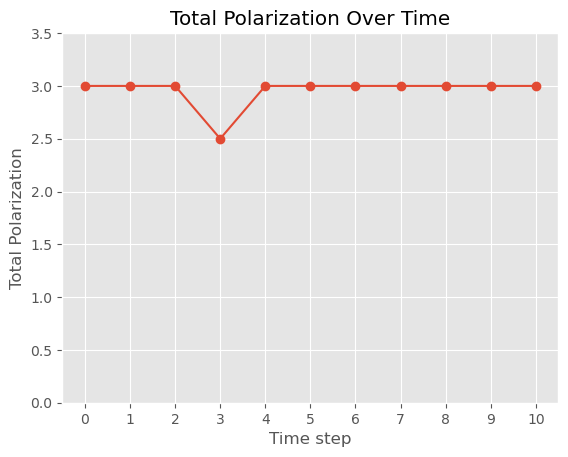

In [30]:
rand_pi_B = random_policy(PB)
simulate_policy_and_plot(PB, rand_pi_B, stiB, itsB, aB, initial_state=(-1,-0.5,0.5,1), filename='GB-Nolearn.png')

Initial state: (-1, -0.5, 0.5, 1)
Round 1: Action (0, 1), Next State (-1.0, -0.5, 0.5, 1.0), Polarization 3.00
Round 2: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 3.00
Round 3: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 4: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 5: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 6: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 7: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 8: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 9: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50
Round 10: Action (0, 1), Next State (-0.5, -0.5, 0.5, 1.0), Polarization 2.50


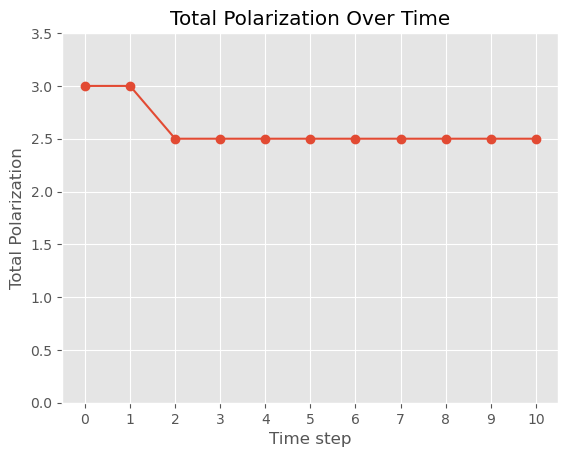

In [31]:
bias_pi_B = biased_policy(PB, aB, itsB)
simulate_policy_and_plot(PB, bias_pi_B, stiB, itsB, aB, initial_state=(-1,-0.5,0.5,1), filename='GB-bias.png')

#### 1-step opinion update visualization (helped me to visuzalize only)

In [32]:
def update_opinion(graph, i, step=0.5, verbose=False):
    '''
    Takes the i-th node of a networkx graph, selects a random neighbor j
    and applies the opinion update according to the specific instructions.
    Requires an 'opinion' attribute.
    Assumes a step of 0.5 in the 'opinion' attribute. 
    Does not require for the nodes to be connected; acts like
    an agent MasterMind outside the graph who connects nodes at will.
    Choose verbose=True to show the print indicators.

    NOTE: In hindsight, not ideal for my particular MDP representation.
    '''
    vprint = print if verbose else lambda *a, **k: None

    
    opinion = nx.get_node_attributes(graph, 'opinion')
    s_i = opinion[i]

    j = random.choice(list(G1.adj[i]))
    s_j = opinion[j]
    vprint(f'\nChose i: {i} and j: {j} \n with initial opinions {s_i} and {s_j} respectively')
    diff = s_j - s_i
    p = np.random.rand()
    
    if abs(diff) == 0:
        vprint(f' Pairs have equal opinions.\n ')
        return s_i     

    
    
    if abs(diff) >= 2*step:
        if p < 0.4:
            graph.nodes[i]['opinion'] = np.clip(s_i + 2* step * np.sign(diff), -1.0 , 1.0)
            vprint(f' i\'s polarization reduced! \n')
            return 
            
        elif p > 0.7:   # 0.4 + 0.3  leaving the 0.3 in between for the last case
            graph.nodes[i]['opinion'] = np.clip(s_i + step * (-1) * np.sign(diff), -1.0 , 1.0)
            vprint(f' i\'s polarization increased!!! \n')
            return 
        
        else:
            vprint(f' i\'s opinion remained unchanged \n ')
            return 
    
    
    if abs(diff) == step:
        if p < 0.6:
            graph.nodes[i]['opinion'] = s_j
            vprint(f' i\'s polarization diminished! \n')
            return 
        else:
            vprint(f' i\'s opinion remained unchanged \n')
            return 

    vprint(f'Something is wrong, check gap or interval. Returned initial value.')
    return

In [33]:
i= random.choice(list(G1.nodes))
print(i)
update_opinion(G1, i, verbose=True)

1

Chose i: 1 and j: 0 
 with initial opinions 1.0 and 0.5 respectively
 i's polarization diminished! 



# TASK 3 : Value Iteration 

Converged after 80 iterations
Initial state: (0.5, -0.5, 1.0, -0.5)
Round 1: Action (2, 3), Next State (0.5, -0.5, 1.0, -0.5), Polarization 2.50
Round 2: Action (2, 3), Next State (0.5, -0.5, 1.0, -0.5), Polarization 2.50
Round 3: Action (2, 3), Next State (0.5, -0.5, 0.0, -0.5), Polarization 2.50
Round 4: Action (0, 2), Next State (0.5, -0.5, 0.0, -0.5), Polarization 1.50
Round 5: Action (0, 2), Next State (0.5, -0.5, 0.0, -0.5), Polarization 1.50
Round 6: Action (0, 2), Next State (0.5, -0.5, 0.0, -0.5), Polarization 1.50
Round 7: Action (0, 2), Next State (0.0, -0.5, 0.0, -0.5), Polarization 1.50
Round 8: Action (1, 0), Next State (0.0, 0.0, 0.0, -0.5), Polarization 1.00
Round 9: Action (3, 2), Next State (0.0, 0.0, 0.0, -0.5), Polarization 0.50
Round 10: Action (3, 2), Next State (0.0, 0.0, 0.0, 0.0), Polarization 0.50
--- Episode Terminated ---


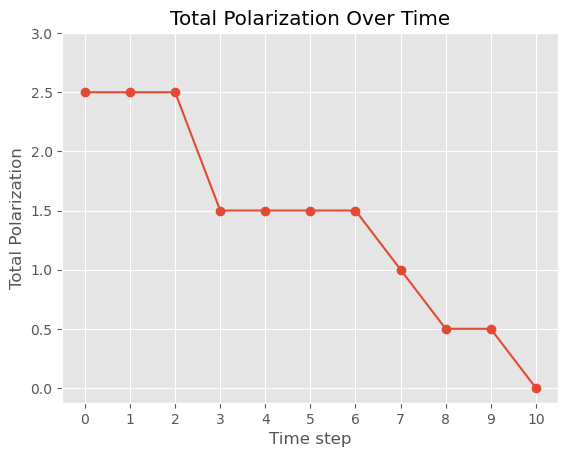

Process took 1.0057 seconds


In [34]:
start = time.time()

VA, pstarA = value_iteration(PA, aA, itsA)
initial_stateA = random.choice(sA)
simulate_policy_and_plot(PA, pstarA, stiA, itsA,aA,initial_stateA, filename='GA-Qlearn.png')

end = time.time()
print(f'Process took {end - start:.4f} seconds')

In [37]:
# VA

Converged after 80 iterations
Initial state: (0.0, 0.5, -0.5, -1.0)
Round 1: Action (3, 0), Next State (0.0, 0.5, -0.5, -1.0), Polarization 2.00
Round 2: Action (3, 0), Next State (0.0, 0.5, -0.5, -1.0), Polarization 2.00
Round 3: Action (3, 0), Next State (0.0, 0.5, -0.5, -1.0), Polarization 2.00
Round 4: Action (3, 0), Next State (0.0, 0.5, -0.5, 0.0), Polarization 2.00
Round 5: Action (2, 3), Next State (0.0, 0.5, 0.0, 0.0), Polarization 1.00
Round 6: Action (1, 0), Next State (0.0, 0.0, 0.0, 0.0), Polarization 0.50
--- Episode Terminated ---


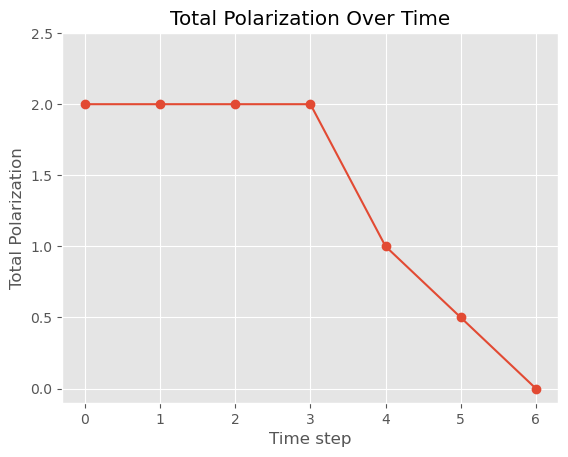

Process took 1.1171 seconds


In [36]:
start = time.time()

VB, pstarB = value_iteration(PB, aB, itsB)
initial_stateB = random.choice(sB)
simulate_policy_and_plot(PB, pstarB, stiB, itsB, aB, initial_stateB, rounds=50, filename='GB-Qlearn.png')

end = time.time()
print(f'Process took {end - start:.4f} seconds')

# VI Validation

In [71]:
# 3-node random net for validation
GVal, sVal, aVal = create_validation_net(3, opinions=[-0.5,0.0,0.5])

Creating graph...
Number of states for this graph: 125 
  Number of possible actions: 4
  Nodes' initial opinions [-0.5, 0.0, 0.5]
  Total polarization: 1.0


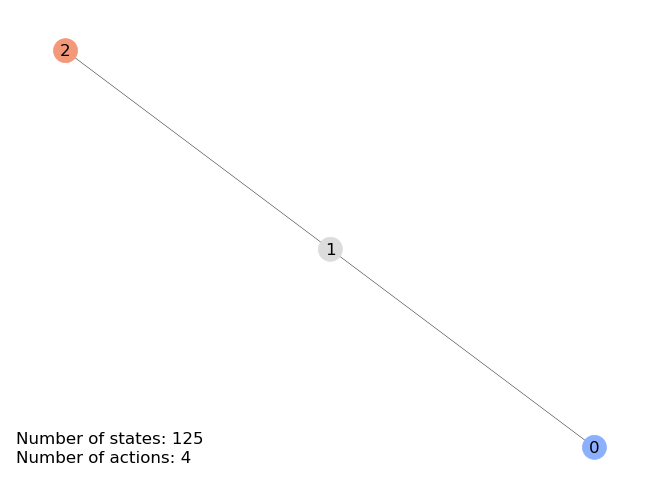

In [72]:
draw_opinion_graph(GVal, random=True, filename='GVal-3.png')

In [75]:
PVal, stiVal, itsVal = create_transition_prob(GVal, sVal, aVal)
VVal, piVal = value_iteration(PVal, aVal, itsVal, verbose=True)

For the graph Graph with 3 nodes and 2 edges 
 \ with Number of states 125 
 \ and number of possible actions 4
 Creating matrix P ...
 P matrix created.
 Format: P[state-index][action-index] = 
       [(probability of transition, next state index number, reward, done)].
State (-1.0, -1.0, -1.0) --> Best action (0, 1)
State (-1.0, -1.0, -0.5) --> Best action (2, 1)
State (-1.0, -1.0, 0.0) --> Best action (1, 2)
State (-1.0, -1.0, 0.5) --> Best action (1, 2)
State (-1.0, -1.0, 1.0) --> Best action (1, 2)
State (-1.0, -0.5, -1.0) --> Best action (1, 2)
State (-1.0, -0.5, -0.5) --> Best action (0, 1)
State (-1.0, -0.5, 0.0) --> Best action (0, 1)
State (-1.0, -0.5, 0.5) --> Best action (1, 2)
State (-1.0, -0.5, 1.0) --> Best action (2, 1)
State (-1.0, 0.0, -1.0) --> Best action (0, 1)
State (-1.0, 0.0, -0.5) --> Best action (0, 1)
State (-1.0, 0.0, 0.0) --> Best action (0, 1)
State (-1.0, 0.0, 0.5) --> Best action (0, 1)
State (-1.0, 0.0, 1.0) --> Best action (0, 1)
State (-1.0, 0.5, -1.0

Initial state: (-0.5, 0.0, 0.5)
Round 1: Action (0, 1), Next State (0.0, 0.0, 0.5), Polarization 1.00
Round 2: Action (2, 1), Next State (0.0, 0.0, 0.0), Polarization 0.50
--- Episode Terminated ---


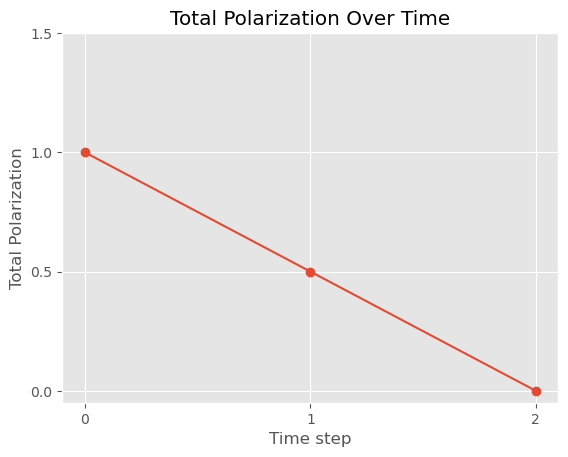

In [76]:
simulate_policy_and_plot(PVal, piVal, stiVal, itsVal, aVal, initial_state=(-0.5,0.0,0.5), filename='GVal-Qlearn.png')

In [78]:
for s_idx, v in enumerate(VVal):
    print(f"State {s_idx} ({itsVal[s_idx]}): V = {v:.4f}")


State 0 ((-1.0, -1.0, -1.0)): V = -23.0000
State 1 ((-1.0, -1.0, -0.5)): V = -28.0000
State 2 ((-1.0, -1.0, 0.0)): V = 14.5000
State 3 ((-1.0, -1.0, 0.5)): V = 11.6667
State 4 ((-1.0, -1.0, 1.0)): V = 8.0000
State 5 ((-1.0, -0.5, -1.0)): V = -28.0000
State 6 ((-1.0, -0.5, -0.5)): V = -26.1667
State 7 ((-1.0, -0.5, 0.0)): V = 16.5000
State 8 ((-1.0, -0.5, 0.5)): V = 10.2143
State 9 ((-1.0, -0.5, 1.0)): V = 11.2500
State 10 ((-1.0, 0.0, -1.0)): V = 14.5000
State 11 ((-1.0, 0.0, -0.5)): V = 16.9167
State 12 ((-1.0, 0.0, 0.0)): V = 18.5000
State 13 ((-1.0, 0.0, 0.5)): V = 16.9167
State 14 ((-1.0, 0.0, 1.0)): V = 14.5000
State 15 ((-1.0, 0.5, -1.0)): V = 11.6667
State 16 ((-1.0, 0.5, -0.5)): V = 14.5000
State 17 ((-1.0, 0.5, 0.0)): V = 16.9167
State 18 ((-1.0, 0.5, 0.5)): V = 14.5000
State 19 ((-1.0, 0.5, 1.0)): V = 11.2500
State 20 ((-1.0, 1.0, -1.0)): V = 8.0000
State 21 ((-1.0, 1.0, -0.5)): V = 11.6667
State 22 ((-1.0, 1.0, 0.0)): V = 14.5000
State 23 ((-1.0, 1.0, 0.5)): V = 11.6667
Stat

In [80]:
VVal, piVal = value_iteration(PVal, aVal, itsVal, gamma=0, verbose=True)
for s_idx, v in enumerate(VVal):
    print(f"State {s_idx} ({itsVal[s_idx]}): V = {v:.4f}")

State (-1.0, -1.0, -1.0) --> Best action (0, 1)
State (-1.0, -1.0, -0.5) --> Best action (1, 2)
State (-1.0, -1.0, 0.0) --> Best action (1, 2)
State (-1.0, -1.0, 0.5) --> Best action (1, 2)
State (-1.0, -1.0, 1.0) --> Best action (1, 2)
State (-1.0, -0.5, -1.0) --> Best action (0, 1)
State (-1.0, -0.5, -0.5) --> Best action (1, 2)
State (-1.0, -0.5, 0.0) --> Best action (0, 1)
State (-1.0, -0.5, 0.5) --> Best action (0, 1)
State (-1.0, -0.5, 1.0) --> Best action (2, 1)
State (-1.0, 0.0, -1.0) --> Best action (0, 1)
State (-1.0, 0.0, -0.5) --> Best action (0, 1)
State (-1.0, 0.0, 0.0) --> Best action (0, 1)
State (-1.0, 0.0, 0.5) --> Best action (0, 1)
State (-1.0, 0.0, 1.0) --> Best action (0, 1)
State (-1.0, 0.5, -1.0) --> Best action (0, 1)
State (-1.0, 0.5, -0.5) --> Best action (0, 1)
State (-1.0, 0.5, 0.0) --> Best action (0, 1)
State (-1.0, 0.5, 0.5) --> Best action (0, 1)
State (-1.0, 0.5, 1.0) --> Best action (0, 1)
State (-1.0, 1.0, -1.0) --> Best action (0, 1)
State (-1.0, 1.

In [87]:
for s_idx, v in enumerate(VVal):
    if s_idx in [38, 62, 63]:
        print(f"State {s_idx} ({itsVal[s_idx]}): V = {v:.4f}")


State 38 ((-0.5, 0.0, 0.5)): V = -0.7000
State 62 ((0.0, 0.0, 0.0)): V = 20.0000
State 63 ((0.0, 0.0, 0.5)): V = 11.8000
